In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = pd.read_pickle('data/original_data/hyper[16_17_20].pkl')
y = pd.read_pickle('data/original_data/mineral[16_17_20].pkl')
y.rename(columns={'Orthoclase':'K-Feldspar'})

,Quartz,K-Feldspar,Alkali-Feldspar,Albite,[Unclassified]
0,0.16,0.60,0.12,0.08,0.04
1,0.40,0.36,0.12,0.04,0.08
2,0.40,0.36,0.12,0.04,0.08
3,0.64,0.16,0.20,0.00,0.00
4,0.76,0.12,0.08,0.00,0.04
...,...,...,...,...,...
15314,0.52,0.28,0.04,0.04,0.12
15315,0.72,0.16,0.08,0.00,0.04
15316,0.40,0.32,0.04,0.00,0.24
15317,0.76,0.04,0.08,0.04,0.08


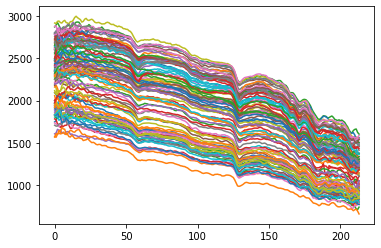

In [3]:
plt.plot(X.sample(100).T)
plt.show()

In [4]:
y.head()

,Quartz,Orthoclase,Alkali-Feldspar,Albite,[Unclassified]
0,0.16,0.60,0.12,0.08,0.04
1,0.40,0.36,0.12,0.04,0.08
2,0.40,0.36,0.12,0.04,0.08
3,0.64,0.16,0.20,0.00,0.00
4,0.76,0.12,0.08,0.00,0.04


In [5]:
y = y.idxmax(axis=1)
print(np.unique(y))

['Alkali-Feldspar' 'Orthoclase' 'Quartz' '[Unclassified]']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
clf = Pipeline([
    ('pca', PCA(n_components=8)),
    ('scale', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(100,20,),max_iter=1000))
])

In [8]:
def scorer(estimator, x, y):
    yh = estimator.predict(x)
    return f1_score(y, yh, average='weighted', zero_division=0)

cv = GridSearchCV(
    clf,
    {'clf__alpha': np.logspace(-5,1,10)},
    scoring=scorer,
    verbose=100
)

cv.fit(X_train, y_train)

clf = cv.best_estimator_
print(f"best alpha: {cv.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__alpha=1e-05 ................................................
[CV] .................... clf__alpha=1e-05, score=0.758, total=  12.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[CV] clf__alpha=1e-05 ................................................
[CV] .................... clf__alpha=1e-05, score=0.748, total=  11.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.2s remaining:    0.0s
[CV] clf__alpha=1e-05 ................................................
[CV] .................... clf__alpha=1e-05, score=0.751, total=  13.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.4s remaining:    0.0s
[CV] clf__alpha=1e-05 ................................................
[CV] .................... clf__alpha=1e-05, score=0.764, total=  14.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ...... clf__alpha=0.46415888336127725, score=0.786, total=   5.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  6.9min remaining:    0.0s
[CV] clf__alpha=0.46415888336127725 ..................................
[CV] ...... clf__alpha=0.46415888336127725, score=0.784, total=   4.9s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  6.9min remaining:    0.0s
[CV] clf__alpha=0.46415888336127725 ..................................
[CV] ...... clf__alpha=0.46415888336127725, score=0.808, total=   4.8s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  7.0min remaining:    0.0s
[CV] clf__alpha=0.46415888336127725 ..................................
[CV] ...... clf__alpha=0.46415888336127725, score=0.801, total=   4.3s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.1min remaining:    0.0s
[CV] clf__alpha=2.154434690031882 ....................................
[CV] ........ clf__alpha=2.154434690031882, score=0.799, total=   3.7s
[Parallel(n_jobs=1)]: Done  41 out of  41

In [9]:
y_hat = clf.predict(X_test)

accuracy: 0.7932114882506528


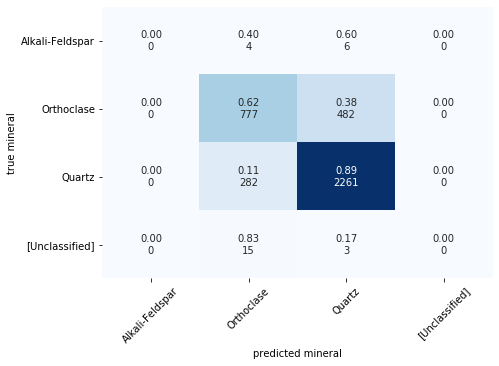

In [10]:
def plot_confusion(y_true, y_pred):
	a = unique_labels(y_true, y_pred)
	plt.figure(figsize=(7,5))
	cm = confusion_matrix(y_true, y_pred, labels=a)
	cm_f = cm / cm.sum(axis=1, keepdims=True)
	annot = np.empty_like(cm).astype(str)
	nr, nc = cm.shape
	for i in range(nr):
		for j in range(nc):
			c = cm[i,j]; f = cm_f[i,j]
			annot[i,j] = "%.2f\n%d" % (f,c)
	cm = pd.DataFrame(cm, index=a, columns=a)
	ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False)
	ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
	ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
	ax.set_ylim(0,len(a))
	ax.invert_yaxis()
	ax.set_xlabel('predicted mineral')
	ax.set_ylabel('true mineral')
	plt.show()

print(f"accuracy: {accuracy_score(y_test, y_hat)}")
plot_confusion(y_test, y_hat)